# Model Airpassengers

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
import time
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def transform_date(date):

    try:

        new_date = date.year + (date.month - 1)/12 + date.day/365

        return new_date
    
    except:

        return float('nan')

In [6]:
def transform_value(value):

    try:

        return float(value)
    
    except:

        return float('nan')

In [7]:
start = time.time()

# Explanation of Input Tensors

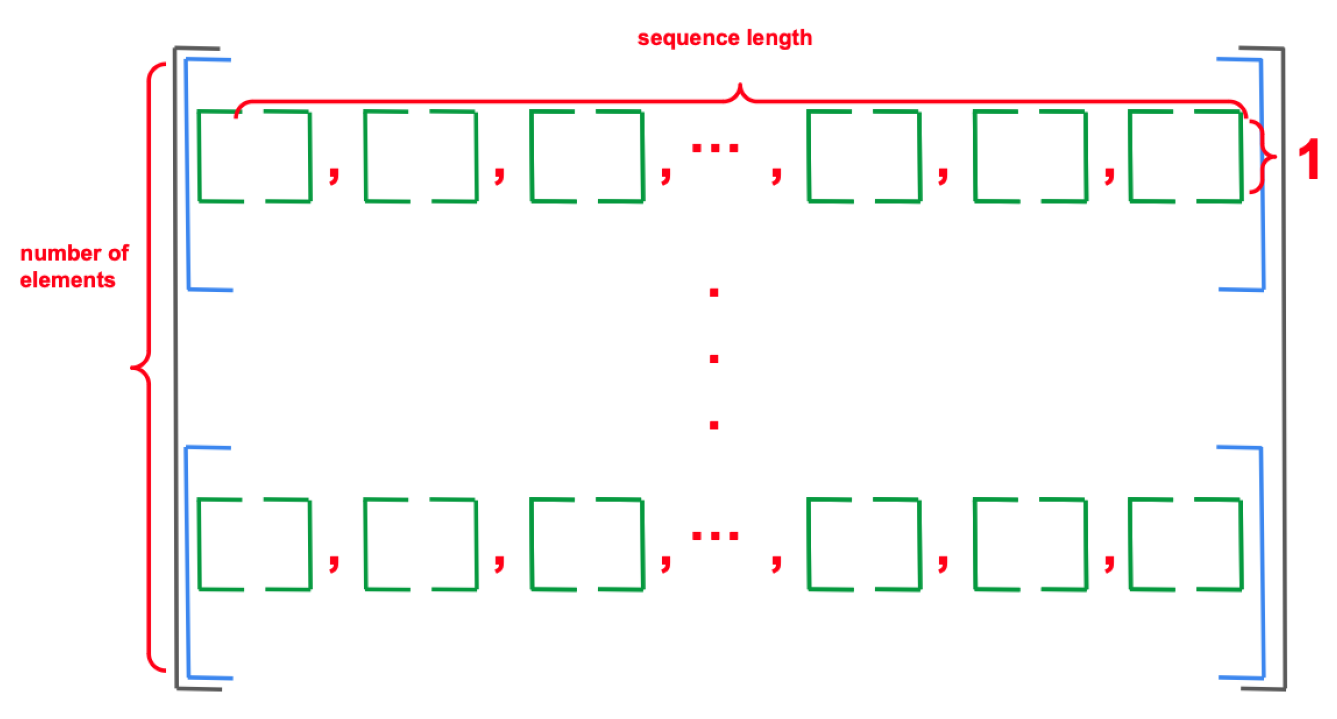

In [9]:
display_img('1.png', 17, 17)

# From Time Series to Tensors

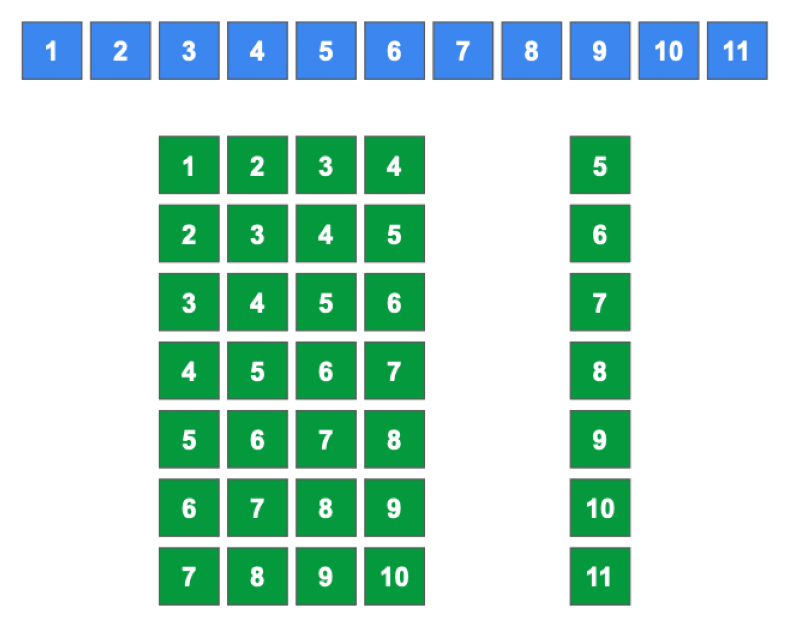

In [11]:
display_img('2.png', 10, 10)

### Comment

We recommend use: 

Sequence length = Period of the Time Series.

# 1. Read DataFrame

In [8]:
df = pd.read_csv('AirPassengers.csv')

df = df.rename(columns = {'Month': 'Time', '#Passengers': 'X_t'})

df['Time'] = pd.to_datetime(df['Time'])

df['Time'] = df['Time'].map(lambda x: transform_date(x))
df['X_t'] = df['X_t'].map(lambda x: transform_value(x))

df = df.dropna()

# 2. Split

In [9]:
train = df[df['Time'] <= 1955]
val = df[(df['Time'] > 1955) & (df['Time'] <= 1958)]
test = df[df['Time'] > 1958]

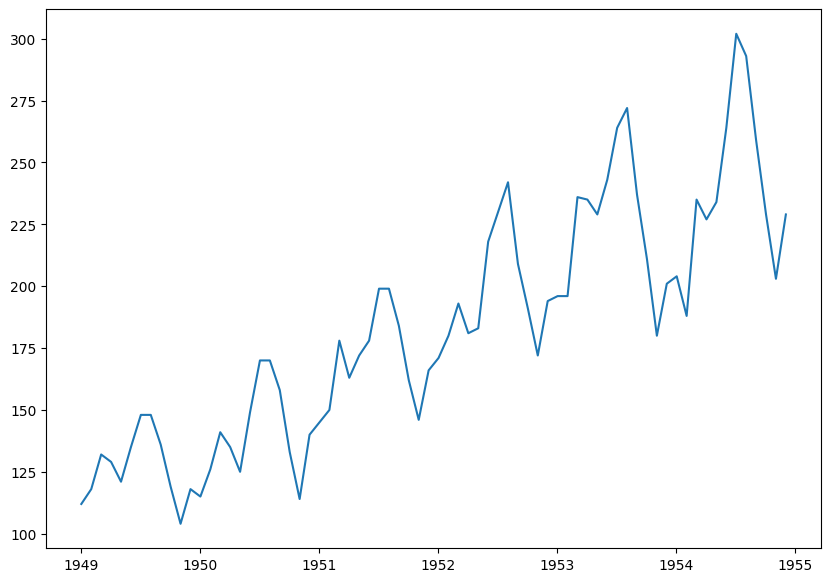

In [10]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'])
plt.show()

# 3. BoxCox

In [11]:
train['log_X_t'] = np.log(train['X_t'])
val['log_X_t'] = np.log(val['X_t'])
test['log_X_t'] = np.log(test['X_t'])

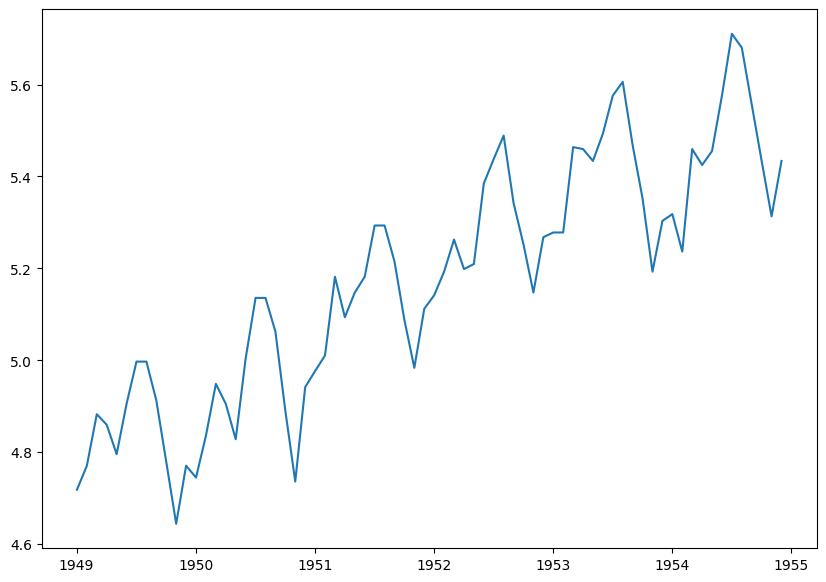

In [12]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_X_t'])
plt.show()

# 4. Exogen Regression

We dont have exogen variables.

# 5. Endogen Regression

We going to use linear trend. 

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
reg = LinearRegression().fit(train[['Time']], train['log_X_t'])

In [15]:
train['log_trend'] = reg.predict(train[['Time']])
val['log_trend'] = reg.predict(val[['Time']])
test['log_trend'] = reg.predict(test[['Time']])

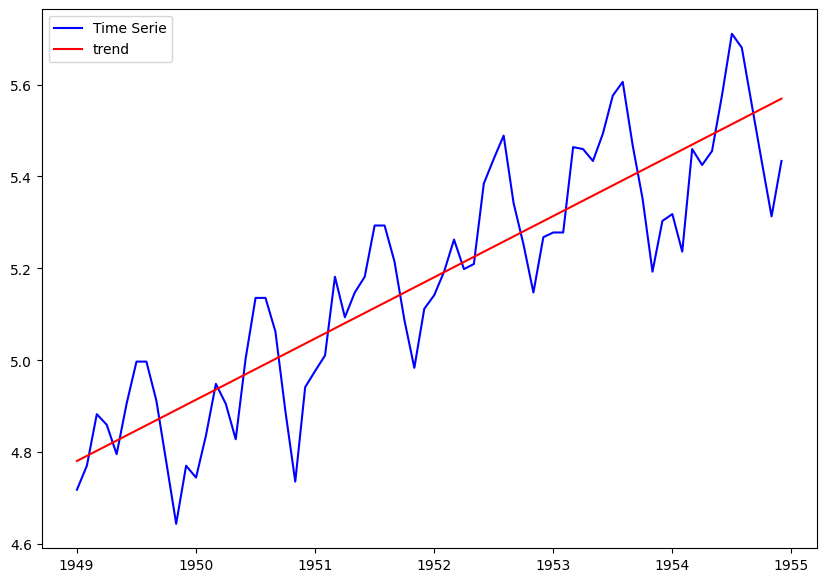

In [16]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_X_t'], color = 'blue', label = 'Time Serie')
plt.plot(train['Time'], train['log_trend'], color = 'red', label = 'trend')
plt.legend()
plt.show()

In [17]:
train['log_error'] = train['log_X_t'] - train['log_trend']
val['log_error'] = val['log_X_t'] - val['log_trend']
test['log_error'] = test['log_X_t'] - test['log_trend']

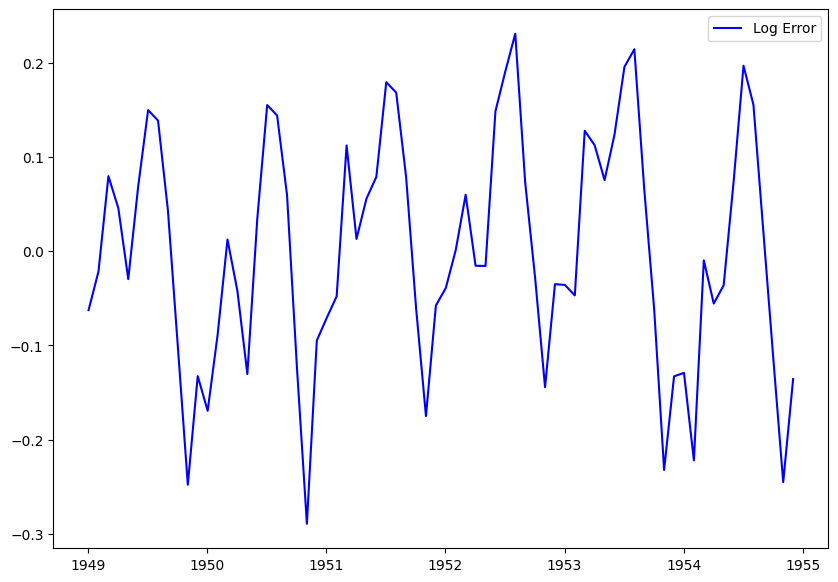

In [18]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_error'], color = 'blue', label = 'Log Error')
plt.legend()
plt.show()

# 6. ACF and PACF

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

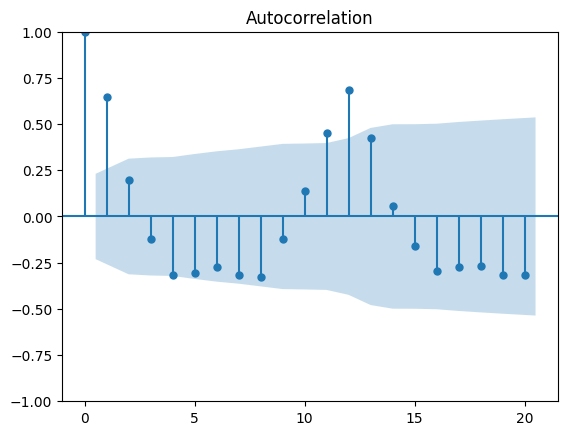

In [20]:
plot_acf(train['log_error'], lags = 20)
plt.show()

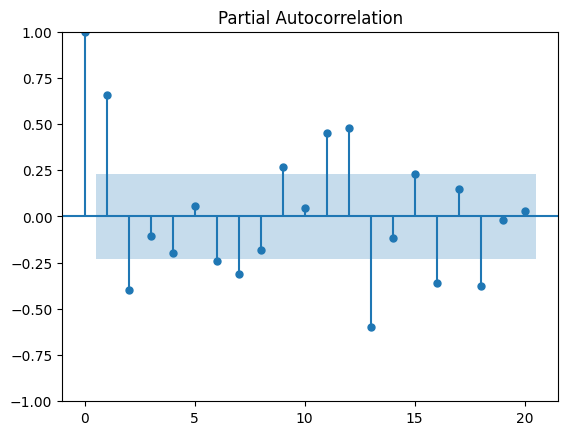

In [21]:
plot_pacf(train['log_error'], lags = 20)
plt.show()

# 7. New period

In [22]:
from scipy import signal

In [23]:
f, Pxx = signal.periodogram(train['log_error'])

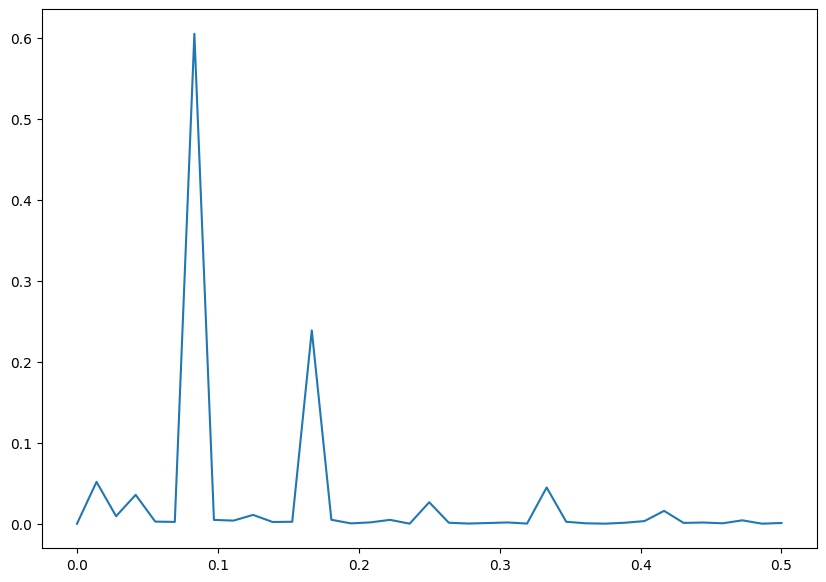

In [24]:
plt.figure(figsize = (10, 7))
plt.plot(f, Pxx)
plt.show()

In [25]:
T = 1/f[Pxx.argmax()]

In [26]:
T

12.0

# 8. Stationary

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
result_log_error = adfuller(train['log_error'].values)

In [29]:
print('ADF Statistic: %f' % result_log_error[0])
print('p-value: %f' % result_log_error[1])
print('Critical Values:')
for key, value in result_log_error[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.222274
p-value: 0.663941
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


**Comments:** Is not stationary.

# 9. New datasets

In [30]:
import torch

In [31]:
chain_train = train[['log_error']].copy()

N_train = len(chain_train)

new_train = []
new_y_train = []

for i in range(N_train - 12):

    new_train.append(np.array(chain_train.iloc[i: i + 12]))
    new_y_train.append([chain_train.loc[i + 12]['log_error']])

In [32]:
new_train = torch.Tensor(new_train)
new_y_train = torch.Tensor(new_y_train)

In [33]:
new_train.shape

torch.Size([60, 12, 1])

In [34]:
new_y_train.shape

torch.Size([60, 1])

# 10. Hyperparameter Tuning

In [35]:
import torch.nn as nn

In [36]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, n_layers):

        super(LSTM, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(self.input_size, self.hidden_dim, self.n_layers, batch_first = True)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(self.hidden_dim*12, output_size)


    def forward(self, x):

        batch_size = len(x)

        h = self.init_hidden(batch_size)
        c = self.init_hidden(batch_size)

        out, (h, c) = self.lstm(x, (h,c))

        out = self.flatten(out)

        out = self.fc(out)

        return out


    def init_hidden(self, batch_size):

        h = torch.zeros(self.n_layers, batch_size, self.hidden_dim)

        return h

In [37]:
def hyperparameter_tuning(input_size, output_size, hidden_dim, n_layers, n_epochs, lr, T):
    
    #----------------------------------------------------------------------

    lstm = LSTM(input_size, output_size, hidden_dim, n_layers)

    criterion = torch.nn.MSELoss()  
    optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

    all_loss_train = []
    all_epochs = []

    for epoch in range(1, n_epochs + 1):
    
        lstm.train()

        optimizer.zero_grad()

        output_train = lstm(new_train)
        loss_train = criterion(output_train, new_y_train)

        loss_train.backward()
        optimizer.step()

        all_loss_train.append(loss_train.item())
        all_epochs.append(epoch)


    #----------------------------------------------------------------------
    
    new_train_part = torch.tensor(np.array([new_train[-1].cpu().detach().numpy()]))

    all_preds_val = []

    for t in range(T + 1):

        predict = lstm(new_train_part)

        all_preds_val.append(predict.item())

        new_train_part = list(new_train_part.cpu().detach().numpy()[0][:, 0]) + [predict.cpu().detach().numpy()[0][0]]
        new_train_part = new_train_part[-12:]

        new_train_part_prev = [[]]

        for j in new_train_part:
            new_train_part_prev[0].append([j])

        new_train_part = torch.tensor(new_train_part_prev)

    all_preds_val = all_preds_val[1:]
    
    #----------------------------------------------------------------------

    error_val = ((np.array(val['log_error']) - np.array(all_preds_val))**2).mean()

    return error_val

In [38]:
input_size = 1
output_size = 1
T = 36

In [39]:
all_hidden_dim = [1, 2, 3, 4, 5]
all_n_layers = [1, 2]
all_n_epochs = [100, 200, 300, 400, 500]
all_lr = [0.01, 0.02, 0.03, 0.04, 0.05]

In [40]:
ht = pd.DataFrame()

all_hd = []
all_nl = []
all_ne = []
all_l = []

all_error_val = []

c = 0
m = 10

start_iter = time.time()

for hidden_dim in all_hidden_dim:
    for n_layers in all_n_layers:
        for n_epochs in all_n_epochs:
            for lr in all_lr:

                c = c + 1

                all_hd.append(hidden_dim)
                all_nl.append(n_layers)
                all_ne.append(n_epochs)
                all_l.append(lr)

                all_error_val.append(hyperparameter_tuning(input_size, output_size, hidden_dim, n_layers, n_epochs, lr, T))

                if (c % m) == 0:

                    end_iter = time.time()

                    delta_iter = (end_iter - start_iter)

                    hours_iter = int(delta_iter/3600)
                    mins_iter = int((delta_iter - hours_iter*3600)/60)
                    segs_iter = int(delta_iter - hours_iter*3600 - mins_iter*60)
                    print(f'c = {c}')
                    print(f'Execute this iteration take us {hours_iter} hours, {mins_iter} minutes and {segs_iter} seconds.')
                    print('-'*70)

                    start_iter = time.time()

ht['hidden_dim'] = all_hd
ht['n_layers'] = all_nl
ht['n_epochs'] = all_ne
ht['lr'] = all_l

ht['error_val'] = all_error_val

c = 10
Execute this iteration take us 0 hours, 0 minutes and 2 seconds.
----------------------------------------------------------------------
c = 20
Execute this iteration take us 0 hours, 0 minutes and 5 seconds.
----------------------------------------------------------------------
c = 30
Execute this iteration take us 0 hours, 0 minutes and 5 seconds.
----------------------------------------------------------------------
c = 40
Execute this iteration take us 0 hours, 0 minutes and 7 seconds.
----------------------------------------------------------------------
c = 50
Execute this iteration take us 0 hours, 0 minutes and 12 seconds.
----------------------------------------------------------------------
c = 60
Execute this iteration take us 0 hours, 0 minutes and 2 seconds.
----------------------------------------------------------------------
c = 70
Execute this iteration take us 0 hours, 0 minutes and 5 seconds.
---------------------------------------------------------------------

In [41]:
param_opt = ht[ht['error_val'] == ht['error_val'].min()].iloc[[0]]

In [42]:
param_opt

,hidden_dim,n_layers,n_epochs,lr,error_val
205,5,1,200,0.01,0.000723


In [43]:
hidden_dim_opt = param_opt['hidden_dim'].iloc[0]
n_layers_opt = param_opt['n_layers'].iloc[0]
n_epochs_opt = param_opt['n_epochs'].iloc[0]
lr_opt = param_opt['lr'].iloc[0]

In [44]:
hidden_dim_opt, n_layers_opt, n_epochs_opt, lr_opt

(5, 1, 200, 0.01)

# 11. Definitive Model

In [45]:
lstm = LSTM(input_size, output_size, hidden_dim_opt, n_layers_opt)

criterion = torch.nn.MSELoss()  
optimizer = torch.optim.Adam(lstm.parameters(), lr = lr_opt)

In [46]:
all_loss_train = []
all_epochs = []

for epoch in range(1, n_epochs_opt + 1):
    
    lstm.train()

    optimizer.zero_grad()

    output_train = lstm(new_train)
    loss_train = criterion(output_train, new_y_train)

    loss_train.backward()
    optimizer.step()

    all_loss_train.append(loss_train.item())
    all_epochs.append(epoch)

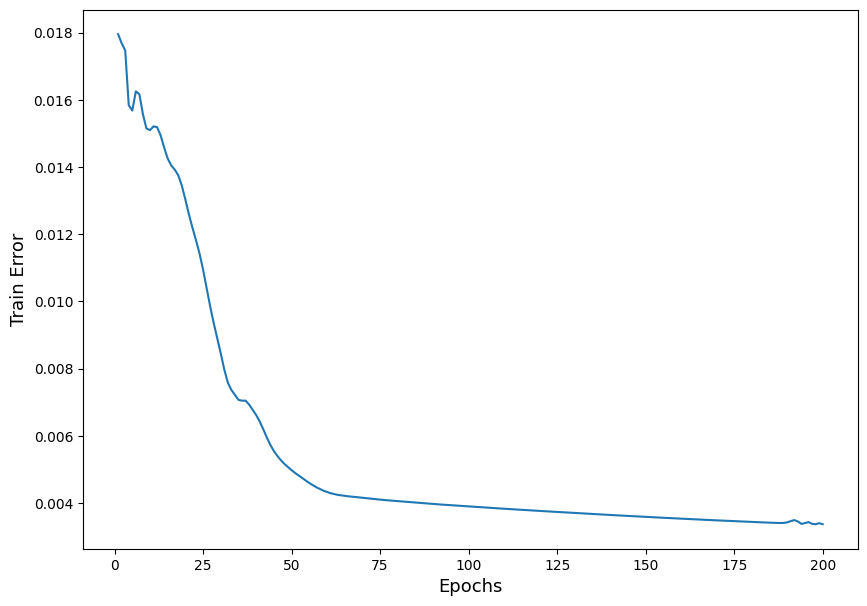

In [47]:
plt.figure(figsize = (10, 7))
plt.plot(all_epochs, all_loss_train)
plt.xlabel('Epochs', fontsize = 13)
plt.ylabel('Train Error', fontsize = 13)
plt.show()

### i. Train

In [48]:
train = train.iloc[12:]

In [49]:
train['log_error_predict'] = list(output_train[:, 0].cpu().detach().numpy())

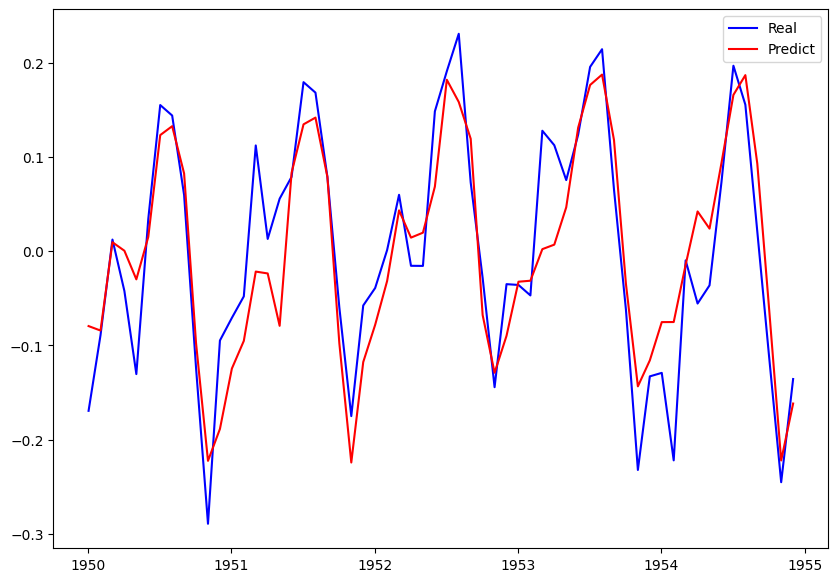

In [50]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_error'], label = 'Real', color = 'blue')
plt.plot(train['Time'], train['log_error_predict'], label = 'Predict', color = 'red')
plt.legend()
plt.show()

### ii. Validation

In [51]:
new_train_part = torch.tensor(np.array([new_train[-1].cpu().detach().numpy()]))

all_preds_val = []

for t in range(72 + 1):

    predict = lstm(new_train_part)

    all_preds_val.append(predict.item())

    new_train_part = list(new_train_part.cpu().detach().numpy()[0][:, 0]) + [predict.cpu().detach().numpy()[0][0]]
    new_train_part = new_train_part[-12:]

    new_train_part_prev = [[]]

    for j in new_train_part:
        new_train_part_prev[0].append([j])

    new_train_part = torch.tensor(new_train_part_prev)

all_preds_val = all_preds_val[1:]

In [52]:
val['log_error_predict'] = all_preds_val[0: 36]
test['log_error_predict'] = all_preds_val[36:]

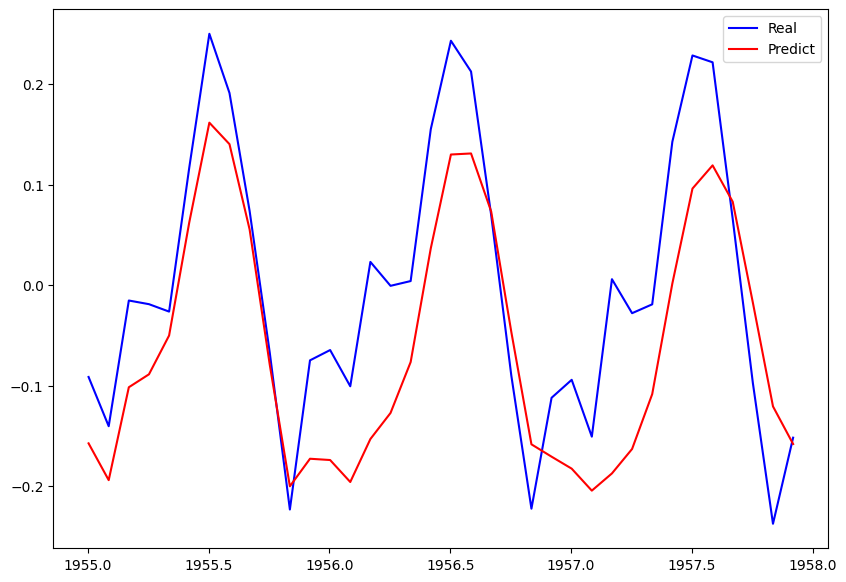

In [53]:
plt.figure(figsize = (10, 7))
plt.plot(val['Time'], val['log_error'], label = 'Real', color = 'blue')
plt.plot(val['Time'], val['log_error_predict'], label = 'Predict', color = 'red')
plt.legend()
plt.show()

### iii. Test

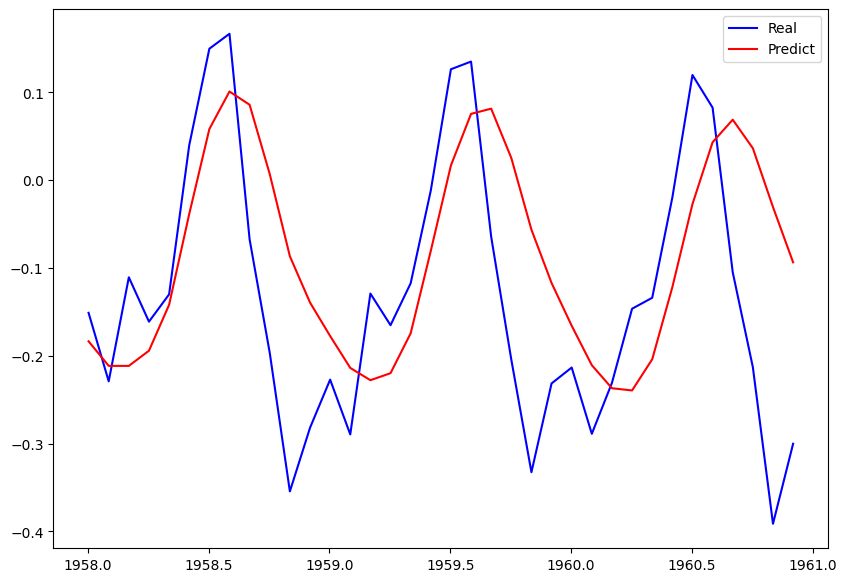

In [54]:
plt.figure(figsize = (10, 7))
plt.plot(test['Time'], test['log_error'], label = 'Real', color = 'blue')
plt.plot(test['Time'], test['log_error_predict'], label = 'Predict', color = 'red')
plt.legend()
plt.show()

# 12. All data

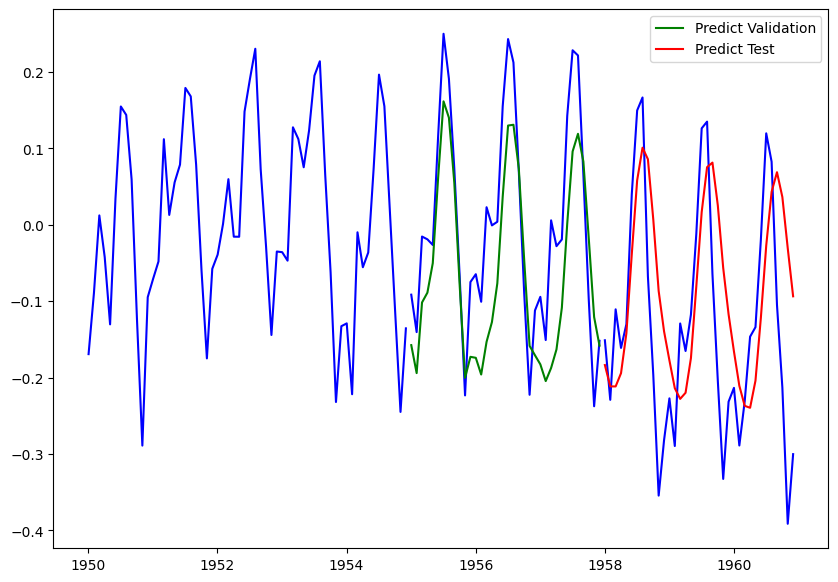

In [55]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_error'], color = 'blue')
plt.plot(val['Time'], val['log_error'], color = 'blue')
plt.plot(test['Time'], test['log_error'], color = 'blue')
plt.plot(val['Time'], val['log_error_predict'], label = 'Predict Validation', color = 'green')
plt.plot(test['Time'], test['log_error_predict'], label = 'Predict Test', color = 'red')
plt.legend()
plt.show()

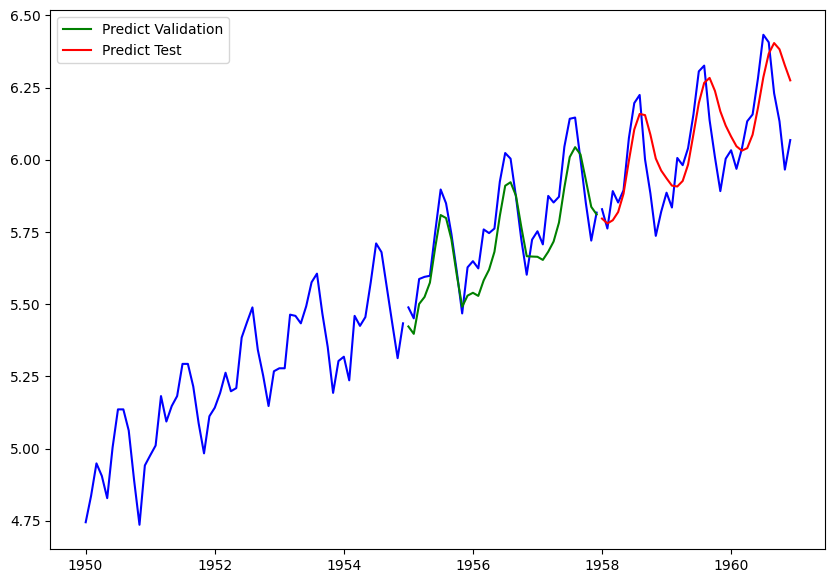

In [56]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['log_X_t'], color = 'blue')
plt.plot(val['Time'], val['log_X_t'], color = 'blue')
plt.plot(test['Time'], test['log_X_t'], color = 'blue')
plt.plot(val['Time'], val['log_error_predict'] + val['log_trend'], label = 'Predict Validation', color = 'green')
plt.plot(test['Time'], test['log_error_predict'] + test['log_trend'], label = 'Predict Test', color = 'red')
plt.legend()
plt.show()

In [57]:
val['predict'] = np.exp(val['log_error_predict'] + val['log_trend'])
test['predict'] = np.exp(test['log_error_predict'] + test['log_trend'])

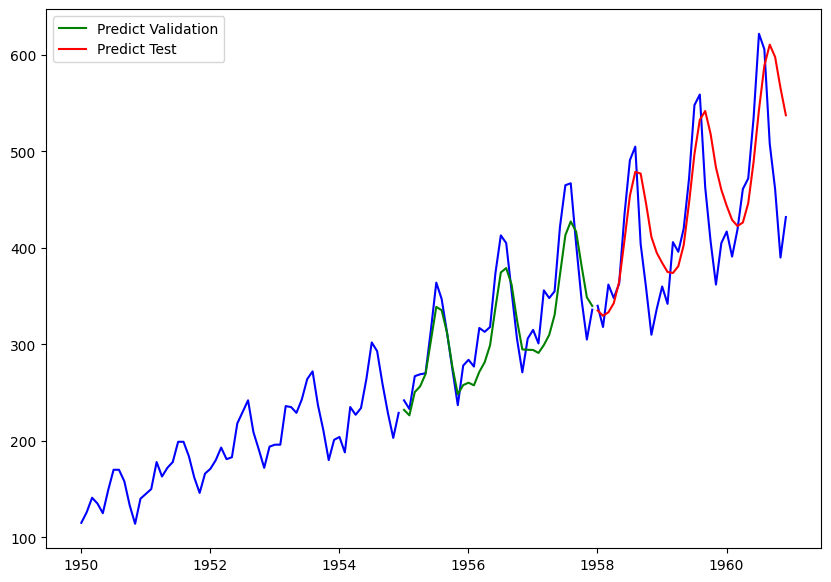

In [58]:
plt.figure(figsize = (10, 7))
plt.plot(train['Time'], train['X_t'], color = 'blue')
plt.plot(val['Time'], val['X_t'], color = 'blue')
plt.plot(test['Time'], test['X_t'], color = 'blue')
plt.plot(val['Time'], val['predict'] + val['log_trend'], label = 'Predict Validation', color = 'green')
plt.plot(test['Time'], test['predict'] + test['log_trend'], label = 'Predict Test', color = 'red')
plt.legend()
plt.show()

# 11. Performance Metrics

In [59]:
print('MSE val:', round(((val['predict'] - val['X_t'])**2).mean(), 2))
print('MAE val:', round((abs(val['predict'] - val['X_t'])).mean(), 2))
print('MAPE val:', round((abs(val['predict'] - val['X_t'])/val['X_t']).mean()*100, 2))

MSE val: 935.72
MAE val: 25.8
MAPE val: 7.65


In [60]:
print('MSE test:', round(((test['predict'] - test['X_t'])**2).mean(), 2))
print('MAE test:', round((abs(test['predict'] - test['X_t'])).mean(), 2))
print('MAPE test:', round((abs(test['predict'] - test['X_t'])/test['X_t']).mean()*100, 2))

MSE test: 4126.15
MAE test: 51.22
MAPE test: 12.18


# 12. Errors

In [61]:
val['error'] = val['X_t'] - val['predict']
test['error'] = test['X_t'] - test['predict']

### i. Normality

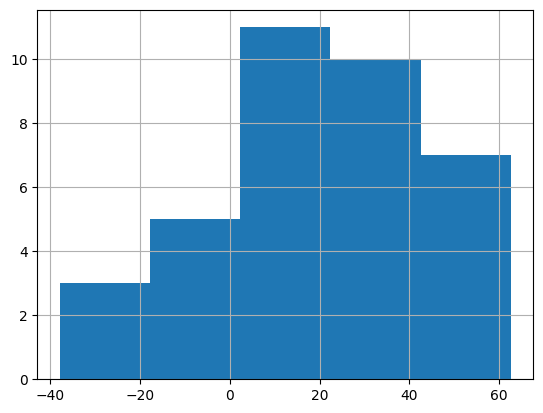

In [62]:
val['error'].hist(bins = 5)
plt.show()

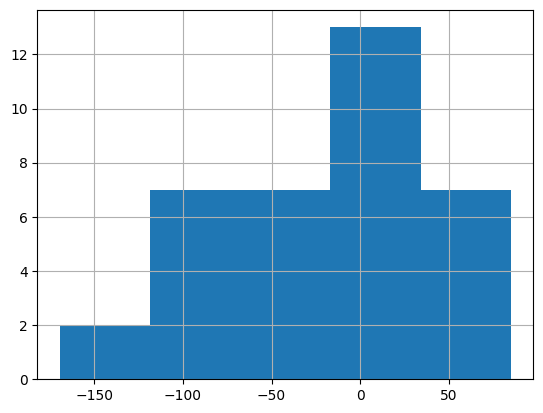

In [63]:
test['error'].hist(bins = 5)
plt.show()

**Comments:** We don't see the normality because with only the histogram is clearly that the errors isn't normals.

### ii. PACF and ACF

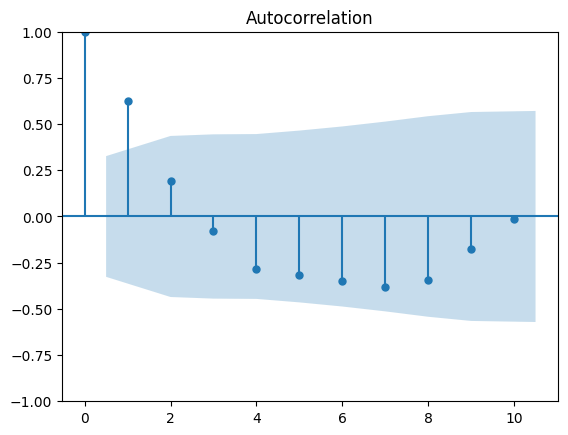

In [64]:
plot_acf(val['error'], lags = 10)
plt.show()

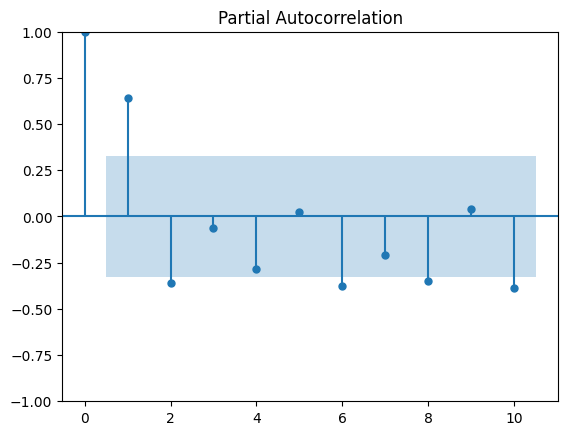

In [65]:
plot_pacf(val['error'], lags = 10)
plt.show()

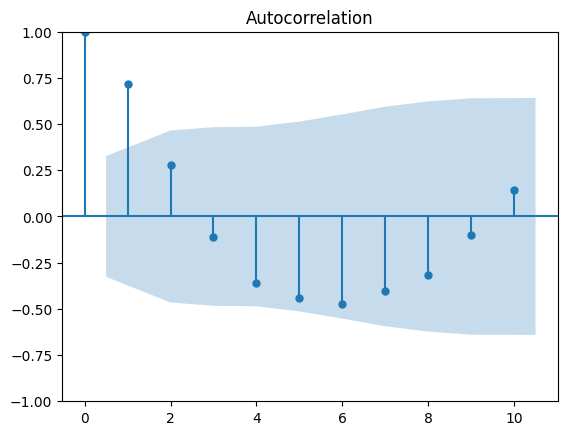

In [66]:
plot_acf(test['error'], lags = 10)
plt.show()

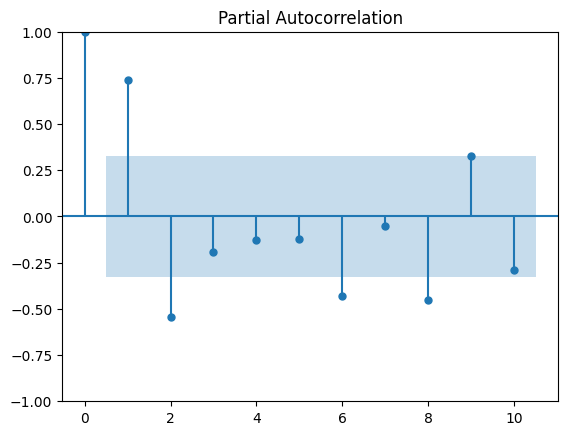

In [67]:
plot_pacf(test['error'], lags = 10)
plt.show()

### iii. Stationary

In [68]:
result_val = adfuller(val['error'].values)

In [69]:
print('ADF Statistic: %f' % result_val[0])
print('p-value: %f' % result_val[1])
print('Critical Values:')
for key, value in result_val[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.888827
p-value: 0.046663
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


**Comment:** Is stationary.

In [70]:
result_test = adfuller(test['error'].values)

In [71]:
print('ADF Statistic: %f' % result_test[0])
print('p-value: %f' % result_test[1])
print('Critical Values:')
for key, value in result_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.897010
p-value: 0.333469
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


**Comment:** Is stationary.

### Time of execution

In [72]:
end = time.time()

In [73]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 3 minutes and 10 seconds.
